# Investigating trends in BMI amongst teenagers in public schools

## Background and Motivation

- [ ] Insert text here

## Preliminary Data Import

- [ ] Add text here

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
# States A - M
dataset = pd.read_csv('databases/states_a-m1.csv')

# States N - Z
dataset = dataset.append(pd.read_csv('databases/states_n-z1.csv'))

# Drop BMI and any without proper age data
dataset = dataset.dropna(subset=["bmi", "age"])

dataset.head()

,sitecode,sitename,sitetype,sitetypenum,year,survyear,weight,stratum,PSU,record,...,qnwenthungry,qnmusclestrength,qnsunscreenuse,qnindoortanning,qnsunburn,qnconcentrating,qncurrentasthma,qnwheresleep,qnspeakenglish,qntransgender
73898,AL,Alabama (AL),State,2.0,1999.0,5.0,203.9870,7.0,2.0,263599.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73899,AL,Alabama (AL),State,2.0,1999.0,5.0,135.9913,9.0,2.0,263600.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73900,AL,Alabama (AL),State,2.0,1999.0,5.0,65.0445,10.0,2.0,263601.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73901,AL,Alabama (AL),State,2.0,1999.0,5.0,116.8801,9.0,2.0,263602.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73904,AL,Alabama (AL),State,2.0,1999.0,5.0,66.6849,22.0,1.0,263605.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Tidying

- [ ] Add text here

In [4]:
# Keep columns pertaining to demographics
demographics = ["sitecode","year","age","sex","race4","race7","stheight","stweight","bmi"]

# Select behavior survey questions
behaviors = ["qnfr1", "qnveg1",'qnsoda1','qnmilk1','qnbk7day','qnpa0day','qnpa7day']
            
# Drop extra values
dataset = dataset[demographics + behaviors]

In [ ]:
# Restructure indicator variables
dataset['veg'] = np.abs(dataset['qnveg1']-2)
dataset['fr'] = np.abs(dataset['qnfr1']-2)
dataset['soda'] = np.abs(dataset['qnsoda1']-2)
dataset['milk'] = np.abs(dataset['qnmilk1']-2)
dataset['brk7'] = np.abs(dataset['qnbk7day']-2)
dataset['act0'] = dataset['qnpa0day']-1
dataset['act7'] = np.abs(dataset['qnpa7day']-2)

In [5]:
# Testing upon sex demographic
dataset["sexlabel"] = dataset["sex"]

# Label as male or female for visibility for x-axis readability
def sexlabeling(x):
        if x == 1.0:
            return "female"
        elif x == 2.0:
            return "male"
        else:
            return np.nan

dataset["sexlabel"] = dataset["sexlabel"].map(sexlabeling)

## Looking for Trends

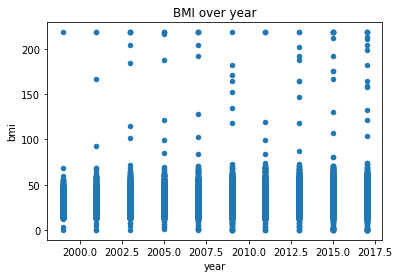

In [7]:
# Scatter of BMIs over time
dataset.plot.scatter(y="bmi", x="year", title="BMI over year")

Text(0.5, 1.0, 'BMI Violin Distributions')

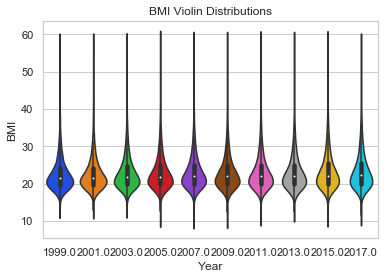

In [8]:
# Clearly there is some error with BMIs over 200, as that would require weights over 500 in children
# so let's cap it at 60. Additionally some seem to drop as low as 0, so I will introduce a floor of 9
dataset = dataset[dataset["bmi"] < 60]
dataset = dataset[dataset["bmi"] > 9]

# Let's only look at ages 13 - 17
dataset = dataset[dataset["age"] < 7]
dataset = dataset[dataset["age"] > 1]

# Also, since the scatterplots are quite dense per survey year, I'd perfer
# Violin Plots

# Set the style
sns.set(style="whitegrid")

# Plot Continent vs Residuals
ax = sns.violinplot(x="year", y="bmi", data=dataset, palette="bright")

# Improve look and Labeling
plt.xlabel("Year")
plt.ylabel("BMI")
plt.title("BMI Violin Distributions")

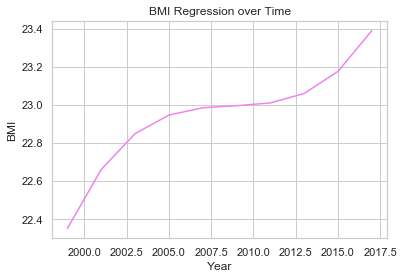

In [9]:
plt.figure()

# Create a regression
reg = np.poly1d(np.polyfit(dataset["year"], dataset["bmi"], 3))

# Find the general trend
plt.plot(dataset["year"].unique(), reg(dataset["year"].unique()), color = "violet")
plt.title("BMI Regression over Time")
plt.xlabel("Year")
plt.ylabel("BMI")
plt.show()

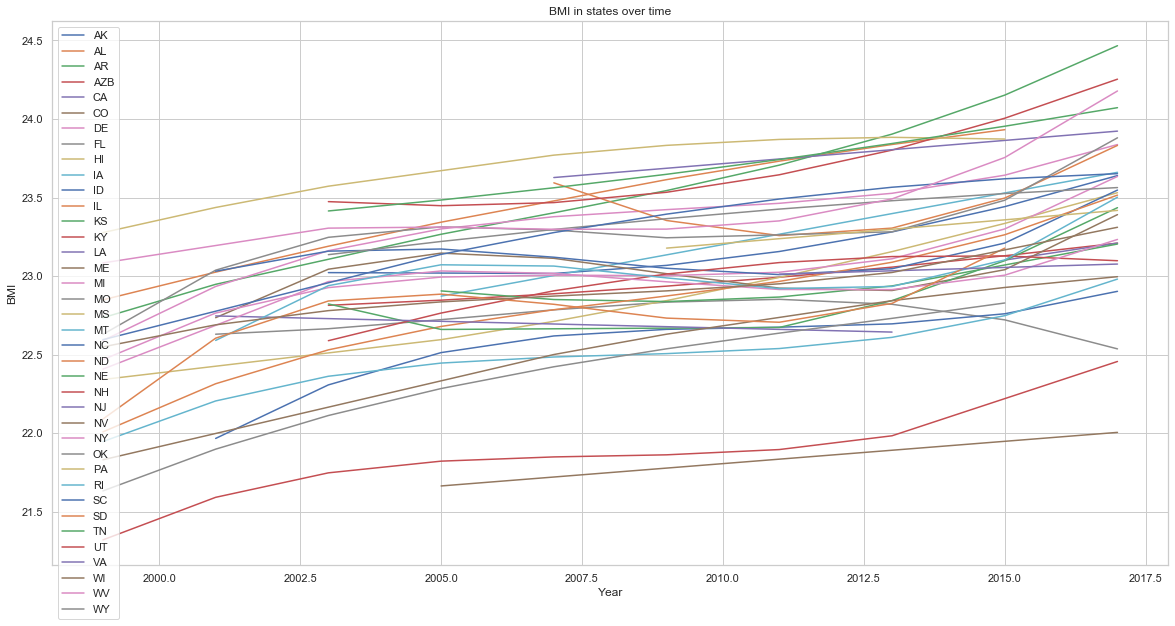

In [10]:
plt.figure(figsize=(20, 10))

# Create a regression per State
for state, datasubset in dataset.groupby("sitecode"):
    # Pick a degree low enough so the rank will be well-conditioned
    # (Some states have very few years of participation)
    deg = int(datasubset["year"].unique().size / 3)
    
    if deg == 0:
        deg = 1
    
    # Regression
    reg = np.poly1d(np.polyfit(datasubset["year"], datasubset["bmi"], deg))
    
    
    plt.plot(datasubset["year"], reg(datasubset["year"]), label=state)
    
    
    
plt.title("BMI in states over time")
plt.xlabel("Year")
plt.ylabel("BMI")
plt.legend(loc="upper left")
plt.show()

Text(0.5, 1.0, 'BMI Distributions between the Sexes')

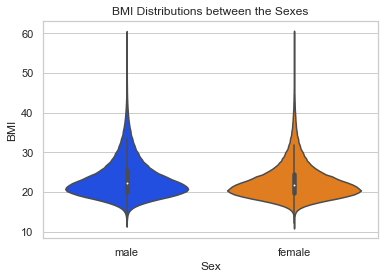

In [11]:
# Set the style
sns.set(style="whitegrid")

# Plot Sex vs BMI
ax = sns.violinplot(x="sexlabel", y="bmi", data=dataset, palette="bright")

# Improve look and Labeling
plt.xlabel("Sex")
plt.ylabel("BMI")
plt.title("BMI Distributions between the Sexes")

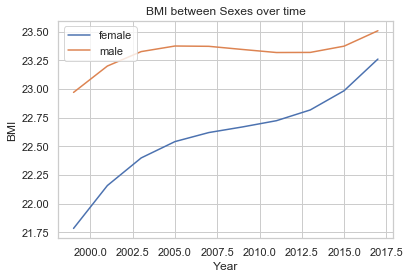

In [12]:
plt.figure()

# Create a regression per State
for sex, datasubset in dataset.groupby("sexlabel"):
    
    # Regression
    reg = np.poly1d(np.polyfit(datasubset["year"], datasubset["bmi"], 3))
    
    
    plt.plot(datasubset["year"].unique(), reg(datasubset["year"].unique()), label=sex)
    
    
    
plt.title("BMI between Sexes over time")
plt.xlabel("Year")
plt.ylabel("BMI")
plt.legend(loc="upper left")
plt.show()

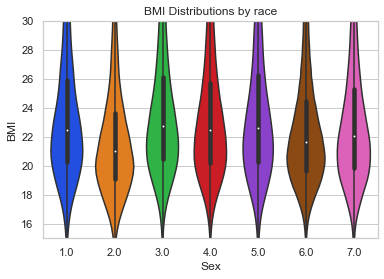

In [14]:
# Set the style
sns.set(style="whitegrid")

dataset["race7label"] = dataset["race7"]

# Plot Sex vs BMI
ax = sns.violinplot(x="race7", y="bmi", data=dataset, palette="bright")

# Improve look and Labeling
plt.xlabel("Sex")
plt.ylabel("BMI")
plt.title("BMI Distributions by race")
plt.ylim(15,30)
plt.show()

In [16]:
def qpercreg(label):
    years = []
    percent = []
    
    for year, datasubset in dataset.dropna(subset=[label]).groupby("year"):
        if not datasubset.empty:
            years.append(year)
            percent.append(datasubset[datasubset[label] == 1.0].shape[0] * 100 / datasubset.shape[0])
    
    return years, percent


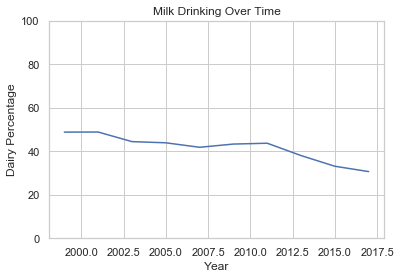

In [17]:
plt.figure()

xvals, yvals = qpercreg("qnmilk1")
plt.plot(xvals, yvals)

plt.title("Milk Drinking Over Time")
plt.xlabel("Year")
plt.ylabel("Dairy Percentage")
plt.ylim(0, 100)
plt.show()

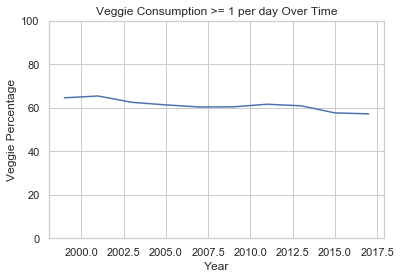

In [18]:
xvals, yvals = qpercreg("qnveg1")

plt.plot(xvals, yvals)

plt.title("Veggie Consumption >= 1 per day Over Time")
plt.xlabel("Year")
plt.ylabel("Veggie Percentage")
plt.ylim(0, 100)
plt.show()

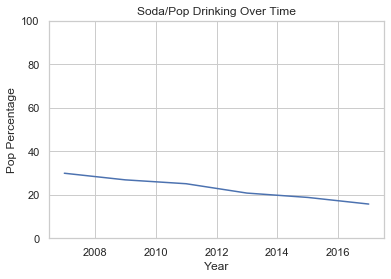

In [19]:
xvals, yvals = qpercreg("qnsoda1")

plt.plot(xvals, yvals)

plt.title("Soda/Pop Drinking Over Time")
plt.xlabel("Year")
plt.ylabel("Pop Percentage")
plt.ylim(0, 100)
plt.show()

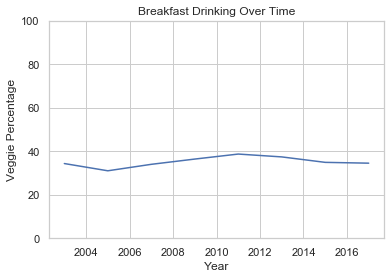

In [20]:
xvals, yvals = qpercreg("qnbk7day")

plt.plot(xvals, yvals)

plt.title("Breakfast Drinking Over Time")
plt.xlabel("Year")
plt.ylabel("Veggie Percentage")
plt.ylim(0, 100)
plt.show()

## Model

In [ ]:
df_x = dataset[['veg','fr','soda','milk','brk7','act7']]
df_y = dataset['bmi'].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=0)

reg = LinearRegression()
reg.fit(x_train, y_train)
coeff_df = pd.DataFrame(reg.coef_, df_x.columns, columns=['Coefficient'])  
coeff_df.head(6)

In [ ]:
y_pred = reg.predict(x_test)
res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Error': y_pred - y_test,'val':1})
res.head(10)

In [ ]:
ax = res.plot(kind='scatter',x='Predicted',y='Actual',color='violet',title='Actual vs Predicted BMI')
ax.set_xlabel('Predicted BMI')
ax.set_ylabel('Actual BMI')
## Calculate trend line
trend = np.polyfit(res.Predicted, res.Actual, 1)
model = np.poly1d(trend)
plt.plot(res.Predicted, model(res.Predicted))
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
bx = sns.violinplot(y='Error',x='val',data=res)
bx.set_title('Residuals')
bx.set_xlabel('BMI')
bx.set_ylabel('Residual')
plt.show()

In [ ]:
df_x = dataset[['veg','fru','soda','milk','brk7','act7']]
df_y = dataset[['bmi']]
reg = LinearRegression()
cv = KFold(n_splits=10, random_state=42, shuffle=False)
res = []
for train_index, test_index in cv.split(df_x):
    x_train, x_test = df_x[df_x.index.isin(train_index)], df_x[df_x.index.isin(test_index)]
    y_train, y_test = df_y[df_y.index.isin(train_index)], df_y[df_y.index.isin(test_index)]
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    res.append(metrics.mean_absolute_error(y_test, y_pred))
print('Average Mean Absolute Error from 10-Fold Cross Validation:',np.mean(res))